In [1]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from math import *
import imageio
from scipy import ndimage, misc
from skimage import morphology
import skimage.measure as measure
import skimage.segmentation as segmentation
import skimage as sk
import pandas as pd

folder = '/home/edo20/PIV'

In [2]:
# Experimental data

# Camera
resolution = (992,1004) #pixel
physical_window = (45,45) # m
pixel_depth = 8 # bit
dynamic_range = 2**pixel_depth # levels
scaling_factor = 1/(np.mean(physical_window)/np.mean(resolution)) # m/pixel
image_number = '030'

In [3]:
frame_a  = tools.imread( folder + '/Images/A' + image_number + 'a.tif' )
frame_b  = tools.imread( folder + '/Images/A' + image_number + 'b.tif' )

In [4]:
def doubleplot(frame_a,frame_b):
    ax = plt.subplot(121)
    ax.imshow(frame_a)
    ax.set_title('Frame a')
    ax2 = plt.subplot(122)
    ax2.imshow(frame_b)
    ax2.set_title('Frame b')


# Image binarization

In [5]:
bin_a = frame_a > 250
bin_b = frame_b > 250

bin_a = bin_a.astype('uint8')
bin_b = bin_b.astype('uint8')

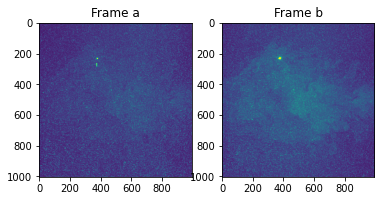

In [6]:
# Set default colormap
# plt.set_cmap(plt.cm.gray)
doubleplot(frame_a, frame_b)

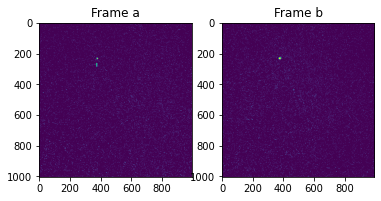

In [7]:
doubleplot(bin_a,bin_b)

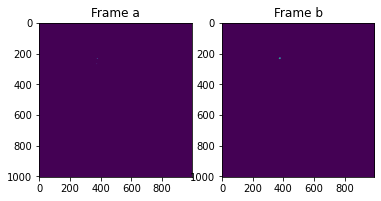

In [8]:
# Erosion to find the "big" regions where brightness is high, element= cross

kernel_size = 5
kernel = np.ones((kernel_size,kernel_size))
iterations = 3

temp_a, temp_b = bin_a, bin_b
for i in range(0,iterations):
    temp_a = morphology.erosion(temp_a)
    temp_b = morphology.erosion(temp_b)

flash_a = temp_a
flash_b = temp_b

doubleplot(flash_a, flash_b)

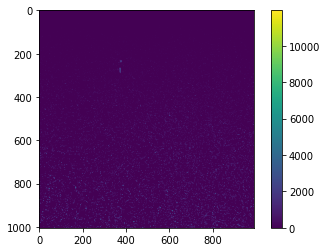

In [9]:
labeled_a = measure.label(bin_a)


plt.imshow(labeled_a)
plt.colorbar()

In [10]:
regions_a = measure.regionprops(labeled_a)

In [11]:
# for i in range(0, max(labeled_a)):
#        if np.any( np.logical_and(flash_a*i == labeled_a, flash_a == 1)):
#            flashindex = i

In [12]:
# np.any( np.logical_and(flash_a*i == labeled_a, flash_a == 1))

(array([], dtype=int64), array([], dtype=int64))
2414.7272727272725


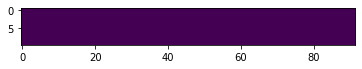

In [13]:
npunti = np.sum(flash_a)
region_label = np.sum(np.multiply(labeled_a,flash_a))/npunti
# region_flash = labeled_a == region_label
region_flash = labeled_a - region_label
#region_flash = np.equal(region_flash, np.zeros(np.shape(labeled_a)))
pippo = region_flash == np.zeros(np.shape(region_flash))
plt.imsave('pippo.png',pippo)
pippo2 = pippo[640:650,900:1000]
plt.imshow(pippo2)
print(np.nonzero(pippo))
# plt.colorbar()
print(region_label)

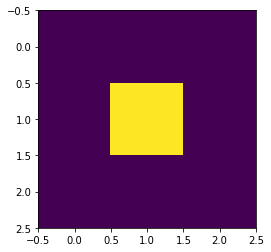

In [14]:
A = np.asarray([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
# B = np.ones((3,3))
B = 4
C = A == B
plt.imshow(C)

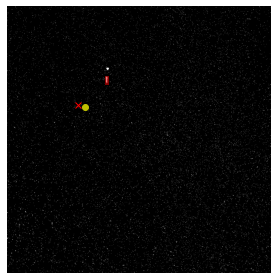

<Figure size 432x288 with 0 Axes>

In [15]:
frame_a = bin_a
tresh = sk.filters.threshold_otsu(frame_a)
bw = sk.morphology.closing(frame_a > tresh, sk.morphology.square(3))
cleared = sk.segmentation.clear_border(bw)
labeled_image = sk.measure.label(cleared)

ax = plt.axes()
ax.imshow(frame_a, cmap=plt.cm.gray)
flashed_regions = []

for region in sk.measure.regionprops(labeled_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2, alpha=0.5)
        ax.add_patch(rect)

        ax.plot(minr,minc,'xr')
        ax.plot(maxr,maxc,'oy')
        

ax.set_axis_off()
plt.tight_layout()
plt.show()
ax.set_axis_off()
plt.savefig('name', dpi = 1000)

In [16]:
plt.imshow(flashed_regions[0].filled_image)
plt.show()
plt.imshow(frame_a[maxr:minr,maxc:minc])
plt.show()

IndexError: list index out of range

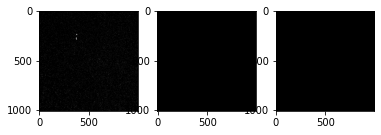

In [17]:
mask = np.zeros_like(frame_a)

ax = plt.subplot(131)
ax.imshow(frame_a, cmap=plt.cm.gray)
for region in flashed_regions:
    min_row, min_col, max_row, max_col = region.bbox
    mask[min_row:max_row,min_col:max_col] = region.filled_image

ax = plt.subplot(132)
ax.imshow(mask, cmap=plt.cm.gray)

# Seed a generator for results to be reproducibles
generator = np.random.default_rng(0)
noise = generator.uniform(0,255, np.shape(mask))
noise = noise*mask

ax = plt.subplot(133)
ax.imshow(noise, cmap=plt.cm.gray)

[[  0.   0.   0. ...   0.   0.   0.]
 [ 27.  23.  18. ...  25.  49.  49.]
 [134.  52.  20. ...  31.  34.  34.]
 ...
 [ 25.  25.  97. ...  27.  23.  23.]
 [ 20.  20.  23. ...  30.  21.  21.]
 [ 21.  19.  18. ...  47.  23.  23.]]


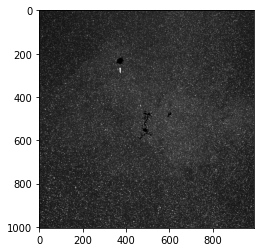

In [47]:
frame_a  = tools.imread( folder + '/Images/A' + image_number + 'a.tif' )
pippo = noise*mask+frame_a*(1-mask)
plt.imshow(pippo, cmap=plt.cm.gray)
print(pippo)

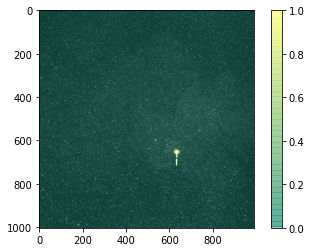

In [64]:
%run -i '/home/edo20/PIV/Scripts/flash_mask'
image_number = '013'
frame_a  = tools.imread( folder + '/Images/A' + image_number + 'a.tif' )
mask,_ = flash_mask(frame_a)
plt.imshow(frame_a, cmap=plt.cm.gray)
plt.imshow(mask, alpha = 0.4, cmap = plt.cm.summer)
plt.colorbar()